In [2]:
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral(Omentum)":"orange",
    "Brain-Caudate(basalganglia)":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed(Suprapubic)":"blue",
    "Skin-SunExposed(Lowerleg)":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m"
        }

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral(Omentum)":"Adipose V.",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "Skin Unexposed",
    "Skin-SunExposed(Lowerleg)":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}

import math
import numpy as np
import os
import pandas as pd
import random
import sys
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

tissu = sorted(COLORS.keys())
CHR = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,'X','Y']
Gene_table = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/FEATURES/Genes_only_table', sep='\t')
Motifs = pd.read_csv('/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed', sep='\t')

In [19]:
top10=[]
All_eSTRs=[]
for Tissue in tissu:
    print(Tissue)
    #HERIT='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/HH/All_genesh2_gcta'
    CAUSE='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/HH/caviar.out'
    LR = '/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/PQValues.txt'
    ANOV = '/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/HH/anova_wg.csv'

    anova = pd.read_csv(ANOV, sep=',')
    anova = anova[['chrom','gene','str.start','anova_pval','estr_fdr','esnp_fdr','delta_bic','delta_aic']]
    
    lr = pd.read_csv(LR,sep='\t')

    Cs=[]
    for i in CHR:
        C=pd.read_csv(CAUSE+str(i), sep='\t')
        Cs.append(C)
    causal=Cs[0]
    for i in range(1,24,1):
        causal=causal.append(Cs[i])   
    CA = causal
    CA.index = CA['gene']
    lr.index = lr['gene']
    Master = pd.merge(lr,CA, on=['chrom','gene'])
    
    print(lr.shape, CA.shape, Master.shape)

    #CAVIAR causality score = product of posterior causal probability 
    #Add gene names, remove duplicate columns and rearrange columns
    genes=Gene_table.loc[Gene_table['gene'].isin(list(Master.index))]
    genes=genes[['gene','chrom','gene.name']]
    #genes.index=genes['gene']
    P = pd.merge(genes,Master, on=['chrom','gene'])
    P['gene.id']=genes['gene']
    del Master['gene']
    P['chrom_x']=P['chrom']
    del P['chrom']
    P['significant'] = np.where(P['qvalue']<=0.1, 1, 0)
    print(sum(list(P['significant'])),'..eSTRs ...')
    Head=['gene.id','chrom_x','gene.name','str.id','best.str.start', 'best.str.score','causality.score','top.variant','top.variant.score', 'significant','anova_pval','delta_bic','delta_aic','p.wald', 'beta','qvalue','NTEST','beta.se', 'estr_fdr','esnp_fdr']
    Master = P[Head]
    Master.columns=['gene','chrom','gene.name','str.id','best.str.start', 'best.str.score','causality.score','top.variant','top.variant.score', 'significant','anova_pval','delta_bic','delta_aic','p.wald', 'beta','qvalue','NTEST','beta.se','estr_fdr','esnp_fdr']
#    Master.to_csv('/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/Master.table', sep='\t',  index=None)
    
    #sort by causality score and select top 10
    P = Master.sort_values('causality.score',ascending = False).head(11)
    top10.append(P)

    #Summary
    c=Master
    estrs = c.loc[c['qvalue']<0.1] 
    print(estrs.shape[0],' eSTRs')
    TOP1 = c.loc[c['top.variant']==c['str.id']]
    TOP2 = estrs.loc[estrs['top.variant']==estrs['str.id']]
    All_eSTRs.append(TOP2)
    print(TOP1.shape[0],' genes for which the top causal variant is the STRs,\n\t including ',TOP2.shape[0],' eSTRs (10% FDR)')
    print('The record (eSTR) with highest causality score is \n')
    print(TOP2.loc[TOP2['causality.score']==max(TOP2['causality.score'])][['str.id','best.str.score','qvalue','causality.score']])
    print(Master.loc[Master['qvalue']<=0.1].shape, '----------------\n')
    
top10s = pd.concat(top10)
print('END!')


##   RUN The following
##python ~/projects/GTEX_eSTRs/gtex-estrs/Scripts/STRs-vs-SNPs_effects/merge_causality_scores.py /storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/ WholeBlood,Cells-Transformedfibroblasts,Muscle-Skeletal,Lung,Artery-Tibial,Adipose-Subcutaneous,Esophagus-Mucosa causality > Merged_Best_causality.Table
##   To merge n select best by tissue


Adipose-Subcutaneous
(15918, 11) (15339, 6) (15339, 15)
0 ..eSTRs ...


KeyError: "['causality.score' 'anova_pval' 'delta_bic' 'delta_aic' 'estr_fdr'\n 'esnp_fdr' 'cis_str_h2' 'num_snps' 'cis_str_h2_pval' 'cis_str_h2_se'\n 'nsamp' 'cis_snp_h2' 'cis_snp_h2_se' 'logL'] not in index"

In [4]:
Master.loc[Master['gene.name'].isin(['CSTB','ARHGAP5','SOX5','KCNN3'])]

,gene,chrom,gene.name,str.id,best.str.start,best.str.score,causality.score,top.variant,top.variant.score,significant,...,estr_fdr,esnp_fdr,cis_str_h2,num_snps,cis_str_h2_pval,cis_str_h2_se,nsamp,cis_snp_h2,cis_snp_h2_se,logL
ENSG00000100852.8,ENSG00000100852.8,chr14,ARHGAP5,STR_32521434,32521434.0,0.979497,0.914729,STR_32521434,0.979497,1,...,0.009886,1.0,0.216422,416.0,0.4221,0.089914,131.0,0.015324,0.065791,-36.207
ENSG00000134532.11,ENSG00000134532.11,chr12,SOX5,STR_23693296,23693296.0,0.010647,0.010647,SNP_23967678,0.087414,0,...,1.000000,1.0,0.072479,1354.0,0.5000,0.095790,123.0,0.000001,0.120847,-42.051
ENSG00000143603.14,ENSG00000143603.14,chr1,KCNN3,STR_154605885,154605885.0,0.014600,0.014600,SNP_154783773,0.030622,0,...,0.901743,1.0,0.063677,715.0,0.5000,0.099075,134.0,0.000001,0.105735,-45.960
ENSG00000160213.5,ENSG00000160213.5,chr21,CSTB,STR_45143020,45143020.0,0.002271,0.001075,SNP_45252030,0.046212,0,...,1.000000,1.0,0.041594,618.0,0.3063,0.117057,95.0,0.046293,0.104463,-35.024


In [17]:

"""plt.plot(Master['best.str.score'],Master['top.variant.score'], 'g.')
plt.xlabel('best str score')
plt.ylabel('top variant score')
plt.show()

X=np.log10(Master['best.str.score'])*(-1)
plt.plot(X, Master['top.variant.score'], 'b.')
plt.xlabel('-Log10(best.str.score)')
plt.ylabel('Top variant score')
plt.show()
S=[]
ST = [list(All_eSTRs[i]["gene"]) for i in range(len(All_eSTRs))]
for i in range(len(ST)):
    S = S+ST[i]
dup=0; count=0

for G in set(S):
    if S.count(G)>1:
        dup=dup+1
        print(G, '-----',S.count(G))
    else:
        count=count+1
    
print  (count, '---', dup, '---', count+dup) #ENSG00000174106.2"""
Master1 = pd.merge(lr,CA, on=['chrom','gene'])
Master1
P1 = pd.merge(genes,Master1, on=['chrom','gene'])
P1

,gene,chrom,gene.name,str.id,str.start,NTEST,p.wald,AD.pval,qvalue,significant,beta,beta.se,best.str.start,best.str.score,top.variant,top.variant.score
0,ENSG00000237683.5,chr1,AL627309.1,STR_62232,62232.0,6,1.872568e-01,1.000000e+00,1.000000,0,0.135747,0.102187,62232,0.003489,SNP_116134,0.105635
1,ENSG00000187634.6,chr1,SAMD11,STR_866512,866512.0,12,4.487721e-02,5.385265e-01,1.000000,0,0.208520,0.102524,866512,0.004993,SNP_850371,0.060334
2,ENSG00000188976.6,chr1,NOC2L,STR_965480,965480.0,12,1.506385e-01,1.000000e+00,1.000000,0,0.150224,0.103639,965480,0.004218,SNP_863521,0.041597
3,ENSG00000187961.9,chr1,KLHL17,STR_965008,965008.0,13,1.927458e-01,1.000000e+00,1.000000,0,0.137027,0.104415,965008,0.003995,SNP_795988,0.020971
4,ENSG00000187583.6,chr1,PLEKHN1,STR_954850,954850.0,13,6.124294e-02,7.961582e-01,1.000000,0,-0.189787,0.100207,954850,0.006834,SNP_906272,0.035736
5,ENSG00000187642.5,chr1,C1orf170,STR_866512,866512.0,13,1.114353e-01,1.000000e+00,1.000000,0,0.166157,0.103371,866512,0.003943,SNP_814743,0.065123
6,ENSG00000188290.6,chr1,HES4,STR_954850,954850.0,13,8.618707e-02,1.000000e+00,1.000000,0,0.174235,0.100501,954850,0.004544,SNP_994391,0.022706
7,ENSG00000187608.5,chr1,ISG15,STR_965522,965522.0,13,8.457484e-02,1.000000e+00,1.000000,0,0.194048,0.111075,965522,0.006368,SNP_936713,0.027261
8,ENSG00000188157.9,chr1,AGRN,STR_965048,965048.0,13,6.797968e-02,8.837358e-01,1.000000,0,-0.222671,0.120001,965048,0.006052,SNP_1081953,0.014942
9,ENSG00000131591.13,chr1,C1orf159,STR_987895,987895.0,10,2.362968e-02,2.362968e-01,0.899646,0,0.257745,0.111569,987895,0.002799,SNP_1047981,0.075025


/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


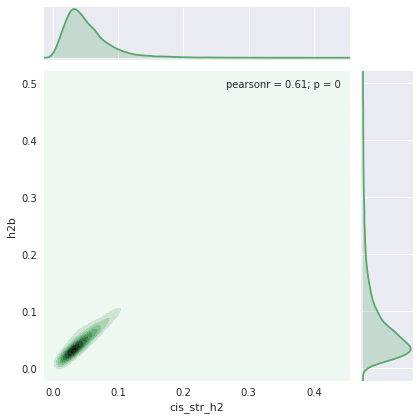

(16111, 25)  After restricting to h2b<=1  (14363, 25)


In [4]:
#Heat scatter plots showing the heritability of each eQTL 
#apportioned to the most significant STR in the cis window 
#x = axis h2_str y = the additive effect from the top 100 most significant SNVs 

Master['h2b']= Master["cis_snp_h2"] + Master["cis_str_h2"]
MM1 = Master.loc[Master['h2b']<=.5]
ESTR = Master.loc[Master['qvalue']<0.1]
#plt.scatter(ESTR['cis_str_h2'],ESTR['h2b'])
sns.jointplot(x="cis_str_h2", y="h2b", data=MM1, kind="kde", color="g")
plt.show()
print (Master.shape, ' After restricting to h2b<=1 ',MM1.shape)